# Ensemble Learning and Random Forests

`Suppose you pose a complex question to thousands of random people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an expert’s answer. This is called the wisdom of the crowd. Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an ensemble; thus, this technique is called Ensemble Learning, and an Ensemble Learning algorithm is called an Ensemble method.`

Source: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition

Example: We can train a group of Decision Tree classifiers, each on a different random subset of the training set. To make predictions, we obtain the predictions of all the individual trees, then predict the class that gets the most votes. Such an ensemble of Decision Trees is called a Random Forest.

The most popular Ensemble methods include:
- bagging,
- boosting,
- stacking


To read:

https://scikit-learn.org/stable/modules/ensemble.html


## Let us load a new toy dataset, called MNIST
https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

In [1]:
import matplotlib.pyplot as plt

# Import datasets, classifiers and performance metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split

digits = datasets.load_digits()

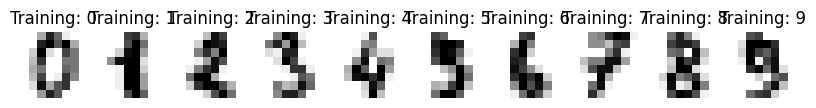

In [2]:
_, axes = plt.subplots(nrows=1, ncols=10, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

In [3]:
# flatten the images
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False
)

## First voting classifier

A simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes. This majority-vote classifier is called a hard voting classifier.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


rnd_clf = RandomForestClassifier()
svm_clf = SVC()
nb_clf = GaussianNB()

voting_clf = VotingClassifier(
    estimators=[('rf', rnd_clf), ('svm', svm_clf), ('nb', nb_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf', RandomForestClassifier()), ('svm', SVC()),
                             ('nb', GaussianNB())])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (rnd_clf, nb_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.9299221357063404
GaussianNB 0.8075639599555061
SVC 0.9610678531701891
VotingClassifier 0.9388209121245829


On the other hand, we can tell Scikit-Learn to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting. All classifiers need to have predict_proba method implemented that return the probabilities. Next we change voting= 'hard' to 'soft' and that's it!.

## Bagging and pasting

In this approach we use the same training algorithm for every predictor and train them on different random subsets of the training set. When sampling is performed with replacement, this method is called **bagging**. When sampling is performed without replacement, it is called **pasting**.

Both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor.

Bagging often results in better models, which explains why it is generally preferred.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True, # this is bagging, set bootstrap=False to use pasting
    n_jobs=-1,
)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=100,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True # In bagging, some instances may be sampled several times for any given predictor, while others may not be sampled at all. We can use them to validate
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9398663697104677

In [8]:
# let's check it!
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.8898776418242491

## Random Forests

Random Forest is an ensemble of Decision Trees, generally trained via the bagging method (or sometimes pasting), typically with max_samples set to the size of the training set.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. The algorithm results in greater tree diversity, which trades a higher bias for a lower variance, generally yielding an overall better model.

Read more about bias vs variance trade-off:
- https://en.wikipedia.org/wiki/Bias–variance_tradeoff
- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html

In [9]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [10]:
accuracy_score(y_test, y_pred_rf)

0.8832035595105673

### Random forests and feature importance

A great quality of Random Forests is that they make it easy to measure the relative importance of each feature. Scikit-Learn measures a feature’s importance by looking at how much the tree nodes that use that feature reduce impurity on average (across all trees in the forest).

In [11]:
import numpy as np
rnd_clf.feature_importances_
img = np.reshape(rnd_clf.feature_importances_, (8, 8))
img

array([[0.        , 0.00295268, 0.02002438, 0.00230331, 0.00111546,
        0.01332771, 0.00532817, 0.        ],
       [0.        , 0.01917035, 0.02378929, 0.00118918, 0.00502025,
        0.01502382, 0.00393946, 0.        ],
       [0.        , 0.00662296, 0.02338772, 0.01886026, 0.02511626,
        0.04646744, 0.01070053, 0.        ],
       [0.        , 0.0139693 , 0.04216515, 0.02584835, 0.04870105,
        0.0207447 , 0.04218513, 0.        ],
       [0.        , 0.0345322 , 0.03213541, 0.01360136, 0.04932156,
        0.02815342, 0.03405949, 0.        ],
       [0.        , 0.01091547, 0.04585051, 0.05635776, 0.03730052,
        0.01777493, 0.02178719, 0.        ],
       [0.        , 0.        , 0.01165717, 0.00998018, 0.01064314,
        0.0210423 , 0.021032  , 0.00083748],
       [0.        , 0.        , 0.01455313, 0.00313454, 0.02126305,
        0.04932391, 0.01599514, 0.00079523]])

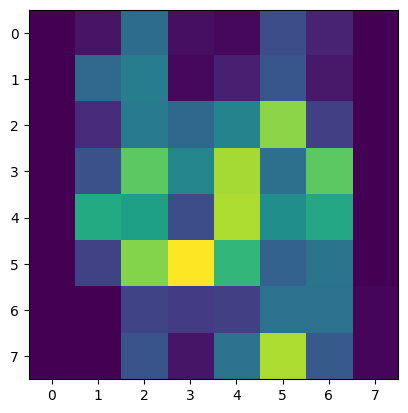

In [12]:
plt.imshow(img)

## Boosting
The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.

### AdaBoost
In AdaBoost, a new predictor tries to correct its predecessor, by paying a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases.

When training an AdaBoost classifier, the algorithm first trains a base classifier and uses it to make predictions on the training set. Next algorithm increases the relative weight of misclassified training instances. Then it trains a second classifier, using the updated weights, and again makes predictions on the training set, updates the instance weights, and so on.

To read:
https://scikit-learn.org/stable/modules/ensemble.html#adaboost

In [13]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [14]:
accuracy_score(y_test, ada_clf.predict(X_test))

0.7686318131256952

## Gradient Boosting
Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. Instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

To read: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.fit(X_train, y_train)

GradientBoostingClassifier()

In [16]:
accuracy_score(y_test, gradient_booster.predict(X_test))

0.8987764182424917

## Stacking

Instead of using trivial functions (such as hard voting) to aggregate the predictions of all predictors in an ensemble, train a model to perform this aggregation.

To read: https://towardsdatascience.com/stacking-made-easy-with-sklearn-e27a0793c92b

In [17]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

base_learners = [
                 ('rf_1', RandomForestClassifier(n_estimators=10, random_state=42)),
                 ('rf_2', KNeighborsClassifier(n_neighbors=5))
                ]

# Initialize Stacking Classifier with the Meta Learner
clf = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

clf.fit(X_train, y_train)


StackingClassifier(estimators=[('rf_1',
                                RandomForestClassifier(n_estimators=10,
                                                       random_state=42)),
                               ('rf_2', KNeighborsClassifier())],
                   final_estimator=LogisticRegression())

In [18]:
accuracy_score(y_test, clf.predict(X_test))

0.9555061179087876

# Task 1
Getting familiar with Kaggle.
Download Titanic data from https://www.kaggle.com/c/titanic/overview and join the competition :)
What I expect:
1. Do not copy code, have fun and play around :)
2. Do initial data exploration
3. Train one of algorithms that you know and evaluate it.
4. Try selecting top features using random forests and teach model using only these features.
5. Use one of above ensemble models and try to score as much as you can.

In [ ]:
!unzip /content/titanic.zip

In [21]:
import pandas as pd

In [64]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

In [65]:
df_train.set_index('PassengerId', inplace=True)
df_test.set_index('PassengerId', inplace=True)

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df_train.drop('Survived', axis=1), df_train['Survived'], test_size=0.2, random_state=1)

In [67]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 302 to 38
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       568 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     165 non-null    object 
 9   Embarked  710 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB


In [68]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,712.000000,568.000000,712.000000,712.000000,712.000000
mean,2.300562,30.166232,0.494382,0.370787,31.951567
std,0.836643,14.856398,1.010478,0.775968,46.313942
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.000000,0.000000,0.000000,7.895800
50%,3.000000,29.000000,0.000000,0.000000,14.458300
75%,3.000000,39.000000,1.000000,0.000000,30.695800
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [69]:
y_train.value_counts()

0    443
1    269
Name: Survived, dtype: int64

In [70]:
y_train.value_counts(normalize=True)

0    0.622191
1    0.377809
Name: Survived, dtype: float64

In [71]:
X_train.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
302,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.2500,NaN,Q
310,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C
517,2,"Lemore, Mrs. (Amelia Milley)",female,34.0,0,0,C.A. 34260,10.5000,F33,S
121,2,"Hickman, Mr. Stanley George",male,21.0,2,0,S.O.C. 14879,73.5000,NaN,S
571,2,"Harris, Mr. George",male,62.0,0,0,S.W./PP 752,10.5000,NaN,S


We want to drop features like name and ticket, they won't be useful for the model

In [72]:
X_train.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X_val.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

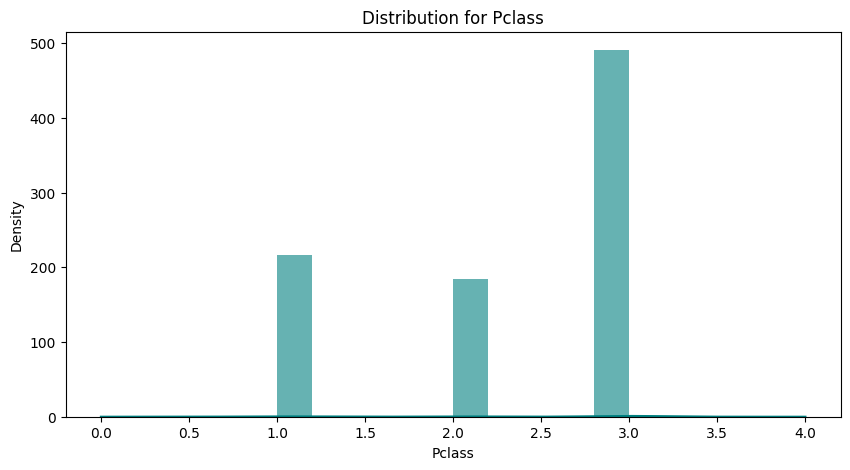

Feature Sex is not a numeric feature


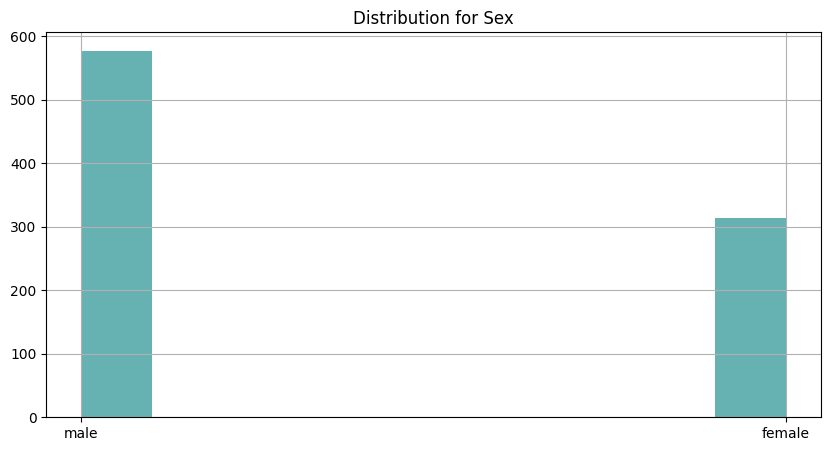

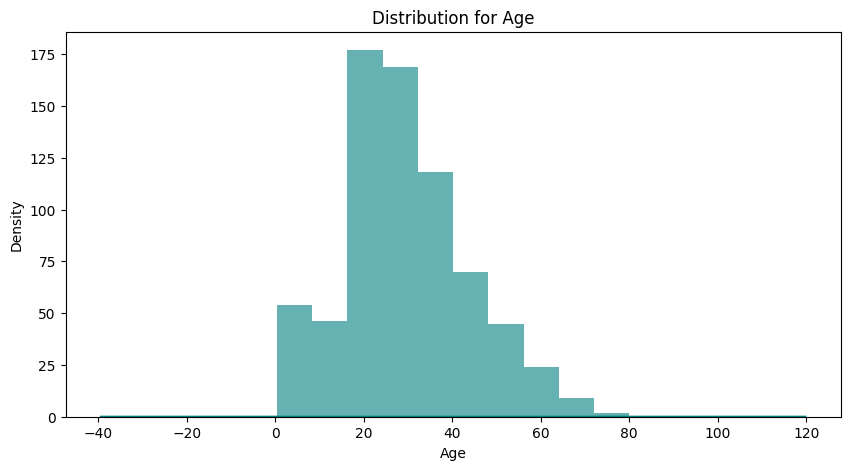

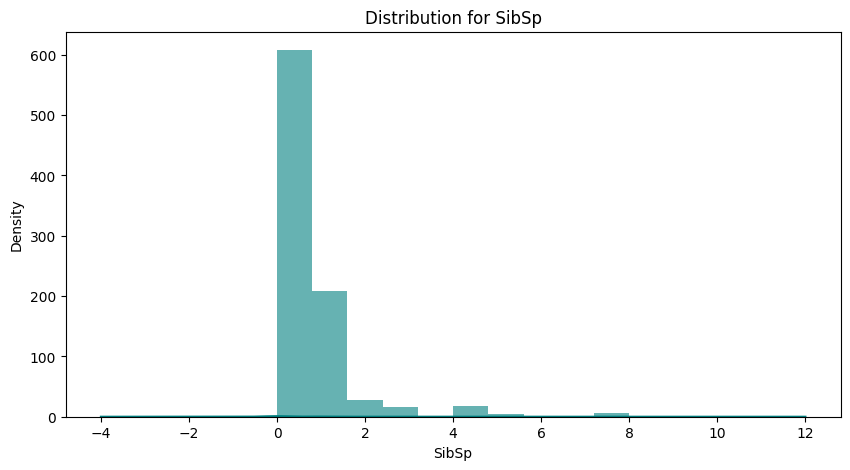

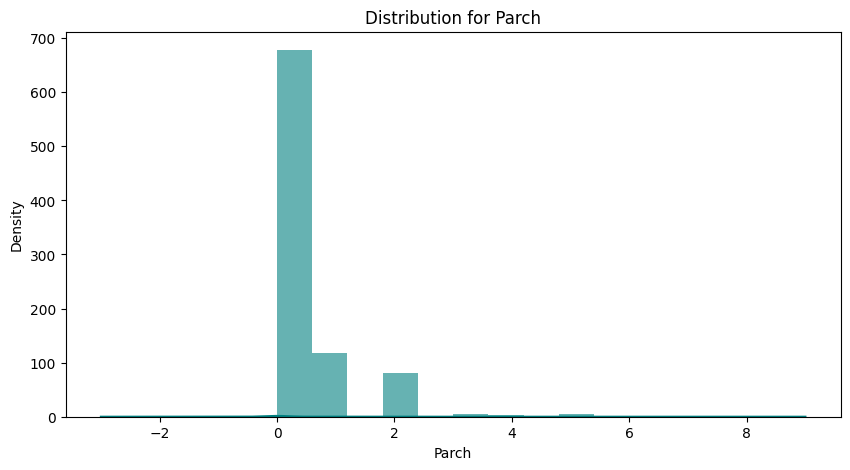

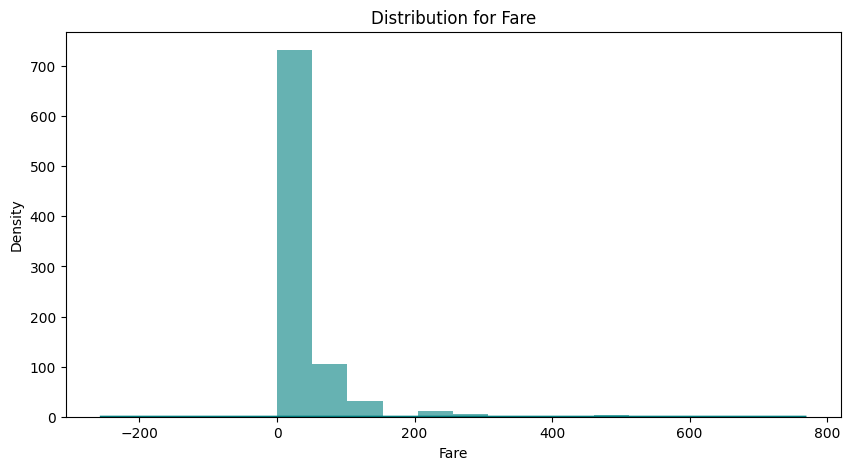

Feature Embarked is not a numeric feature


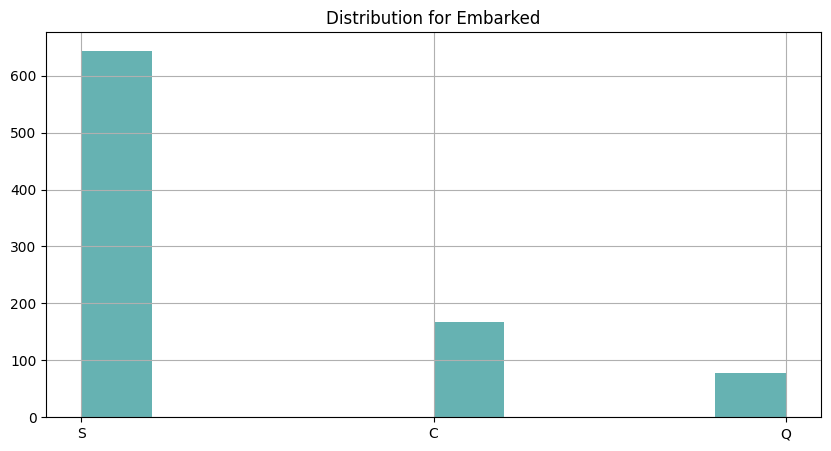

In [73]:
def plot_distribution(feature):
    plt.figure(figsize=(10,5))
    plt.title("Distribution for {}".format(feature))
    ax = df_train[feature].hist(bins=10, stacked=True, color='teal', alpha=0.6)
    df_train[feature].plot(kind='density', color='teal')
    ax.set(xlabel=feature)
    plt.show()



for feature in X_train.columns:
  try:
    plot_distribution(feature)
  except:
    print(f'Feature {feature} is not a numeric feature')

In [74]:
# fill missing values in column Age with median age
X_train['Age'].fillna(df_train['Age'].median(), inplace=True)
X_val['Age'].fillna(df_test['Age'].median(), inplace=True)

# fill missing values in column Embarked with most frequent value
X_train['Embarked'].fillna(df_train['Embarked'].value_counts().index[0], inplace=True)
X_val['Embarked'].fillna(df_test['Embarked'].value_counts().index[0], inplace=True)

# fill missing values in column Fare with median fare
X_val['Fare'].fillna(df_test['Fare'].median(), inplace=True)

# check if there are any missing values left
X_train.isnull().sum()
X_val.isnull().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [76]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for feature in X_train.columns:
    if X_train[feature].dtype == 'object':
        X_train[feature] = le.fit_transform(X_train[feature])
        X_val[feature] = le.fit_transform(X_val[feature])

In [77]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
302,3,1,28.0,2,0,23.2500,1
310,1,0,30.0,0,0,56.9292,0
517,2,0,34.0,0,0,10.5000,2
121,2,1,21.0,2,0,73.5000,2
571,2,1,62.0,0,0,10.5000,2


In [78]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rf.fit(X_train, y_train)
predictions = rf.predict(X_val)

from sklearn.metrics import classification_report

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       106
           1       0.84      0.58      0.68        73

    accuracy                           0.78       179
   macro avg       0.80      0.75      0.76       179
weighted avg       0.79      0.78      0.77       179



In [84]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)).fit(X_train, y_train)

selector.get_support()

array([False,  True, False, False, False,  True, False])

In [86]:
selector.get_feature_names_out()

array(['Sex', 'Fare'], dtype=object)

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
rf.fit(X_train[['Sex', 'Fare']], y_train)
predictions = rf.predict(X_val[['Sex', 'Fare']])

from sklearn.metrics import classification_report

print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       106
           1       0.79      0.63      0.70        73

    accuracy                           0.78       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.78      0.78      0.78       179



Results are pretty similar for both models.

In [89]:
gradient_booster = GradientBoostingClassifier(learning_rate=0.1)
gradient_booster.fit(X_train, y_train)

preds = gradient_booster.predict(X_val)


print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.76      0.93      0.84       106
           1       0.86      0.58      0.69        73

    accuracy                           0.79       179
   macro avg       0.81      0.75      0.76       179
weighted avg       0.80      0.79      0.78       179



In [92]:
# make parameters grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'max_features': [3, 4, 5, 6],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
}

# perform grid search

from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# print best parameters
print(grid_search.best_params_)

# print best score
print(grid_search.best_score_)

# make predictions on validation set
predictions = grid_search.predict(X_val)

# create classification report
print(classification_report(y_val, predictions))

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
{'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
0.8399283764138566
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       106
           1       0.89      0.55      0.68        73

    accuracy                           0.79       179
   macro avg       0.82      0.75      0.76       179
weighted avg       0.81      0.79      0.77       179

